# Introduction

Welcome to the PyAT tutorial.
Here we will go through some of the basic syntax of PyAT. Slowly evolving into more complex examples.
The outline of the tutorial is as follows:
>    1. Defining some simple elements and creating a lattice object
>    2. Simple tracking, orbit correction, radiation flags
>    3. Accessing and modifying ring elements
>    4. Matching



First we can import PyAT (and other useful packages) and see all accessible functions using dir

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import at
#dir(at)

Many functions! But we cannot do anything because we do not have a lattice. Let's define some key parameters for a DBA lattice. Here I am simply taking the values from the at/machine_data/dba.m file

I want to define a drift. But how do I know what to provide to the function? We can use 'help' or ? to tell us.

All elements are found in the file:
> at/pyat/at/lattice/elements.py

This can also be accessed by:

In [2]:
dir(at.elements)

['ABC',
 'Aperture',
 'BeamMoments',
 'Bend',
 'CLASS_MAP',
 'Collective',
 'Collimator',
 'Corrector',
 'Dipole',
 'Drift',
 'Element',
 'EnergyLoss',
 'Generator',
 'Iterable',
 'LongElement',
 'LongtMotion',
 'M66',
 'Marker',
 'Monitor',
 'Multipole',
 'Octupole',
 'Optional',
 'Quadrupole',
 'QuantumDiffusion',
 'RFCavity',
 'Radiative',
 'Sextupole',
 'SimpleQuantDiff',
 'ThinMultipole',
 'Wiggler',
 '_DictLongtMotion',
 '_Radiative',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_array',
 '_array66',
 '_nop',
 'abc',
 'annotations',
 'build_class_map',
 'copy',
 'deepcopy',
 'get_class_map',
 'numpy',
 're']

In [3]:
#help(at.elements.Drift)
at.elements.Drift?

Init signature: at.elements.Drift(family_name: 'str', length: 'float', **kwargs)
Docstring:      Drift space element
Init docstring:
Args:
    family_name:    Name of the element
    length:         Element length [m]

Default PassMethod: ``DriftPass``
File:           /mnt/multipath-shares/machfs/carver/pyat_dev/at/pyat/at/lattice/elements.py
Type:           type
Subclasses:     Collimator


We can see that we need to provide first a 'family_name' as a string, and a 'length' as a float. We can also use the dir function to see all available attributes that can be accessed from the drift.

In [4]:
DR_24 = at.Drift('DR_24', 2.4)

# To see all of the available attributes
dir(DR_24)
# i.e. Length can be re-set by DR_24.Length = New_Length

['FamName',
 'Length',
 'PassMethod',
 '_BUILD_ATTRIBUTES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_conversions',
 '_entrance_fields',
 '_exit_fields',
 '_get_collective',
 '_get_longt_motion',
 '_no_swap',
 '_part',
 'copy',
 'deepcopy',
 'divide',
 'equals',
 'insert',
 'is_collective',
 'is_compatible',
 'items',
 'longt_motion',
 'merge',
 'swap_faces',
 'track',
 'update']

## A note on pointers 

Python uses pointers. When creating a lattice, this can cause some headaches. Observe the following simple examples:

In [5]:
a = np.arange(10) #the array is assigned some memory
b = a #b is now a pointer to the location of the memory for a
b[5] = 100 #we modify b[5], but it also modifies a due to pointers
print(a)

[  0   1   2   3   4 100   6   7   8   9]


In [6]:
drift = at.Drift('Test',5) # Drift of length 5m
pointer_test = [drift, drift] # Here we make a list of 2 drifts of 5m each

# Now we can reduce the length of the first drift
pointer_test[0].Length = 2
print(pointer_test[0].Length, pointer_test[1].Length)

2.0 2.0




As you can see, the drift variable was placed twice in the list. When you modify the length of one, you are in fact modifying all. This can cause issues if you predefine elements (drifts, quads, sexts) and then place them in multiple places in the lattice. One must be careful!

We can perform similar actions to define the needed dipoles, quadrupoles, sextupoles and markers

In [7]:
Nhalfcells = 25 #actually it is 50 half cells
K_QF1 = 0.38041 #Strength of the quadrupoles
K_QD2 = -0.2708
K_QD3 = -0.33319
K_QF4 = 0.4588

Ks = 0.1 # Strength of the sextupoles
L1 = 3

# get arc lattice structure
arc_half=[at.Drift('DR_01', L1*6/8),
          at.Quadrupole('QF1', L1/4, K_QF1),
          at.Drift('DR_02', L1*2/8),
          at.Quadrupole('QD2', L1/4, K_QD2),
          at.Drift('DR_03', L1*2/8),
          at.Bend('Bend', L1, 2*np.pi/(2*Nhalfcells)),          
          at.Drift('DR_04', L1/16),
          at.Quadrupole('QD3', L1/4, K_QD3),
          at.Drift('DR_05', L1/16),
          at.Sextupole('SD', L1/16, -Ks),
          at.Drift('DR_06', L1*3/16),
          at.Quadrupole('QF4', L1/4, K_QF4),
          at.Drift('DR_07', L1/16),
          at.Sextupole('SF', L1/4, Ks)
          ]

We have made a list of elements that represent a half cell consisting of drifts, dipoles, quadrupoles and sextupoles. This is just a python list. We will now use this half, make a full cell (first half + reverse of the first half) and convert it into a lattice object and start to benefit greatly from what PyAT has to offer.

In [8]:
arc_half_copy = copy.deepcopy(arc_half) #This is to avoid problems with pointers when copying the half arc
arc = arc_half + [at.Monitor('BPM_CellCenter')] + arc_half_copy[::-1] #We also add a monitor in the center for later on
arc = at.Lattice(arc, energy=3e9)
print('Periodicity:', arc.periodicity)


Periodicity: 25


As can be seen. We had to define the energy of the ring. The periodicity of the ring has been automatically set based on the total bending angle of the cell. We can do a quick check of the linear optics using the plot_beta function.

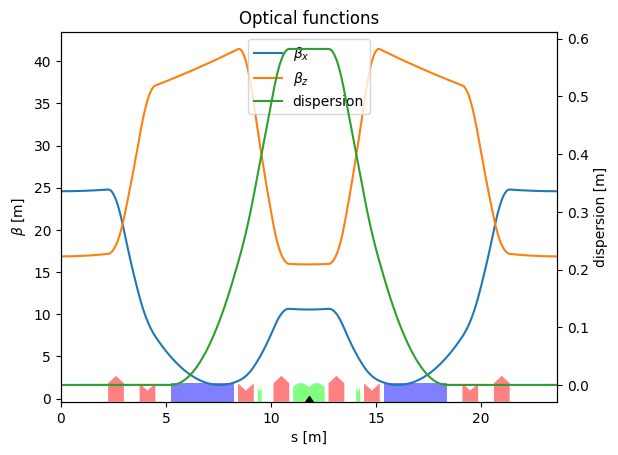

(<AxesSubplot:title={'center':'Optical functions'}, xlabel='s [m]', ylabel='$\\beta$ [m]'>,
 <AxesSubplot:ylabel='dispersion [m]'>,
 <AxesSubplot:>)

In [9]:
import at.plot
arc.plot_beta()

Lets now make a full ring of 25 cells.

In [10]:
ring = []
for i in np.arange(int(Nhalfcells)):
    ring += copy.deepcopy(arc)
    ring += [at.Monitor('BPM_SS')]
    ring += [at.Corrector('Corrector', 0, [0, 0])]

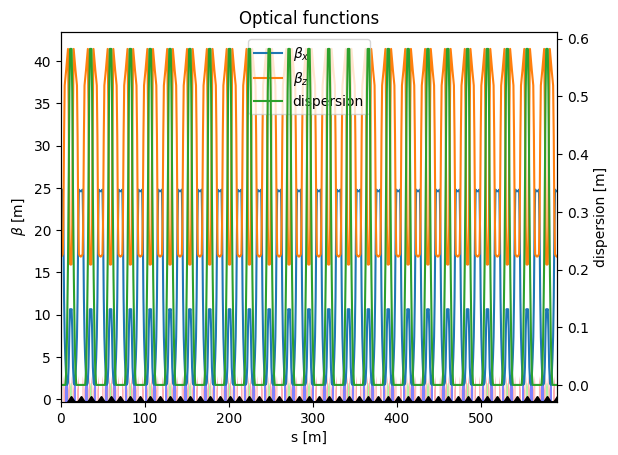

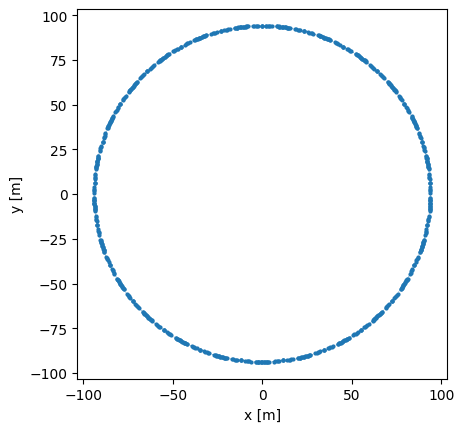

Signature:
ring.plot_geometry(
    start_coordinates: 'tuple[float, float, float]' = (0, 0, 0),
    centered: 'bool' = False,
    ax: 'Axes' = None,
    **kwargs,
)
Docstring:
Compute and plot the 2D ring geometry in cartesian coordinates.

Parameters:
    ring: Lattice description
    start_coordinates: x,y,angle at starting point
    centered: it True the coordinates origin is the center of the ring
    ax: axes for the plot. If not given, new axes are created

Keyword arguments are forwarded to the underlying
:py:func:`~matplotlib.pyplot.plot` function

Returns:
    geomdata: recarray containing, x, y, angle
    radius: machine radius
    ax: plot axis

Example:
    >>> ring.plot_geometry()
File:      /mnt/multipath-shares/machfs/carver/pyat_dev/at/pyat/at/plot/standalone.py
Type:      method


In [11]:
ring = at.Lattice(ring, energy=3e9)
ring.plot_beta() 
geom,radius,ax = ring.plot_geometry(centered=True)
ring.plot_geometry?

Lets check to see if our ring has the correct total bending angle. For this we need to use some functions to access certain lattice elements.

Here we will use 'get_uint32_index'. For all of these kinds of functions, you can specify either a string 'BPM' or a string with a wildcard 'BPM*' or an element in order to select the correct indices. More detail will be provded later on how to access and modify lattice elements. But for now we can see:

In [12]:
bpm_inds = at.get_uint32_index(ring,'BPM*')

bpm_inds = at.get_uint32_index(ring, at.Monitor)
print(len(bpm_inds))



50


So what do we want to do? We want to look at every Bend element, and look at its 'BendingAngle' attribute, then sum them all. To achieve this, we can use 'get_value_refpts. This uses 'get_uint32_index' to get the appropriate indexes for the elements, then extracts the given Attribute Name.

In [13]:
dipole_bending_angles = at.get_value_refpts(ring, at.elements.Bend, 'BendingAngle')
np.sum(dipole_bending_angles) -  2 * np.pi

0.0

In [14]:
quad_strengths = at.get_value_refpts(ring, at.elements.Quadrupole, 'PolynomB', 1)
#This searches in ring, for all elements that match a quadrupole, then finds
#the PolynomB attribute, and takes the second index (python indexes start at 0)

quad_strengths

array([ 0.38041, -0.2708 , -0.33319,  0.4588 ,  0.4588 , -0.33319,
       -0.2708 ,  0.38041,  0.38041, -0.2708 , -0.33319,  0.4588 ,
        0.4588 , -0.33319, -0.2708 ,  0.38041,  0.38041, -0.2708 ,
       -0.33319,  0.4588 ,  0.4588 , -0.33319, -0.2708 ,  0.38041,
        0.38041, -0.2708 , -0.33319,  0.4588 ,  0.4588 , -0.33319,
       -0.2708 ,  0.38041,  0.38041, -0.2708 , -0.33319,  0.4588 ,
        0.4588 , -0.33319, -0.2708 ,  0.38041,  0.38041, -0.2708 ,
       -0.33319,  0.4588 ,  0.4588 , -0.33319, -0.2708 ,  0.38041,
        0.38041, -0.2708 , -0.33319,  0.4588 ,  0.4588 , -0.33319,
       -0.2708 ,  0.38041,  0.38041, -0.2708 , -0.33319,  0.4588 ,
        0.4588 , -0.33319, -0.2708 ,  0.38041,  0.38041, -0.2708 ,
       -0.33319,  0.4588 ,  0.4588 , -0.33319, -0.2708 ,  0.38041,
        0.38041, -0.2708 , -0.33319,  0.4588 ,  0.4588 , -0.33319,
       -0.2708 ,  0.38041,  0.38041, -0.2708 , -0.33319,  0.4588 ,
        0.4588 , -0.33319, -0.2708 ,  0.38041,  0.38041, -0.27

Similarly, parameters can be set using 'set_value_refpts'. For example, lets increase all quadrupole strengths by 1%

For the final part of this lattice building section. We must discuss something very important.

If you call 'set_value_refpts' with copy=False (default behaviour), the values that you set will be modified for the ring lattice.
If you call it with copy=True, you function will return a copy of the original lattice with the modifications made, so the correct usage is

In [15]:
new_ring = at.set_value_refpts(ring, at.elements.Quadrupole, 'PolynomB', quad_strengths*5, 1, copy=True)
print(np.sum(at.get_value_refpts(ring, at.Quadrupole, 'PolynomB', 1)))
print(np.sum(at.get_value_refpts(new_ring, at.Quadrupole, 'PolynomB', 1)))

11.761000000000001
58.805000000000014


This question of in-place modification will show up in many different locations (tracking, radiation flags).

We have one thing missing! An RF Cavity! Let's generate it and then place it in the straight section of the 4th cell. We can use the BPM in the center of the straight section to find the right index

In [16]:
from at.constants import clight
dir(at.constants)

['Cgamma',
 'Cq',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_cst',
 '_e_radius',
 '_hbar_c',
 '_sqrt',
 'clight',
 'e_mass',
 'p_mass',
 'pi',
 'qe']

In [17]:
#at.elements.RFCavity?
harmonic_number = 992
frf = harmonic_number * clight / ring.circumference
rfca = at.elements.RFCavity('RF_Cavity', 0, 5e6, frf-100, harmonic_number, ring.energy, PassMethod='IdentityPass') 
#From the help, we can see we need family_name, length, voltage, frequency, harmonic_number, energy
straight_section_inds = at.get_uint32_index(ring, 'BPM_SS')
ring.insert(straight_section_inds[2], rfca)

In [17]:
straight_section_inds

array([ 29,  60,  91, 122, 153, 184, 215, 246, 277, 308, 339, 370, 401,
       432, 463, 494, 525, 556, 587, 618, 649, 680, 711, 742, 773],
      dtype=uint32)

In [18]:
at.get_uint32_index(ring, 'RF*')

array([91], dtype=uint32)

There are many other handy functions for modifying the lattice in this way including a lot of the standard python list modifications. These will be covered in detail in the next notebook.



Now we have a pretty realistic looking lattice. But at the moment the radiation is off and longitudinal motion is disabled. Lets first enable the 6D tracking and finish setting up the cavity.
There are two functions for this:

> ring.enable_6d

> ring.disable_6d

When we ask to switch on 6D, the function goes through every single pass method in the lattice, and if an equivalent pass method exists that contains the ending '*RadPass' instead of '*Pass' then it updates the pass method. It also switches all RFCavity elements to have CavityPass. The information in the help of the function allows the user to specifically give pass methods for certain groups of elements. 

When ring.disable_6d is called, the pass methods ending in *RadPass* are switched to their *Pass* equivalents, and the RFCavity is switched to IdentityPass (i.e. nothing) if it has length 0, or DriftPass if it has a non-zero length. This effectively disables longitudinal tracking, which is necessary for the accurate computation of uncoupled linear optics.


In [19]:
ring.enable_6d()
print(np.unique(at.get_value_refpts(ring, np.arange(len(ring)), 'PassMethod')))
ring.disable_6d()
print(np.unique(at.get_value_refpts(ring, np.arange(len(ring)), 'PassMethod')))


['BndMPoleSymplectic4RadPass' 'CorrectorPass' 'DriftPass' 'IdentityPass'
 'RFCavityPass' 'StrMPoleSymplectic4Pass' 'StrMPoleSymplectic4RadPass']
['BndMPoleSymplectic4Pass' 'CorrectorPass' 'DriftPass' 'IdentityPass'
 'StrMPoleSymplectic4Pass']


In [ ]:
# cavity on, radiation on
ring.enable_6d()

#cavity on, radiation off
ring.disable_6d(cavity_pass='RFCavityPass')

#cavity off, radiation on
ring.enable_6d(cavity_pass='IdentityPass')

#cavity off, radiation off
ring.disable_6d()

Now we can switch on 6D tracking and use some in built lattice functions to set the RF frequency and the cavity phase.

In [19]:
ring.enable_6d()
freq_old = ring.get_rf_frequency()
ring.set_rf_frequency()
freq_new = ring.get_rf_frequency()
freq_old - freq_new

-100.0

In [20]:
print(freq_old/1e6, 'MHz')
print(freq_new/1e6, 'MHz')
print(ring.harmonic_number, ring.revolution_frequency*ring.harmonic_number/1e6)

503.5243331614815 MHz
503.5244331614815 MHz
992 503.5244331614815


As you can see. our initial guess of 352 MHz was not good for the specified harmonic number. In this simple case set_rf_frequency has applied the RF frequency from harmonic_number*f0.

We can also set the timelag of the cavity. If the TimeLag of the cavity is 0, the there is no phase shift on the RF wave, and the beam will settle itself at a synchronous position where it recovers the energy loss per turn. We can use the function 'set_cavity_phase' to numerically compute the value needed to ensure the beam oscillation point is at ct=0.

In [21]:
print(ring.get_rf_timelag())
ring.set_cavity_phase()
print(ring.get_rf_timelag())

0.0
0.0056910420684217885


We now have a pretty functional lattice. We can now use the function 'envelope_parameters' to numerically compute some interesting and important parameters (emittances, synchrotron frequency, damping numbers)

In [22]:
envelope = at.envelope_parameters(ring)
print(envelope)

  Frac. tunes (6D motion): [0.44976772 0.82375107 0.01324872]
                   Energy: 3.000000e+09 eV
       Energy loss / turn: 3.001470e+05 eV
          Mode emittances: [7.43505870e-09 6.21205223e-38 1.30912010e-06]
Damping partition numbers: [0.99736993 0.99999969 2.00263038]
            Damping times: [0.03948775 0.0393839  0.01966608] s
            Energy spread: 0.000525758
             Bunch length: 0.00249121 m
         Cavities voltage: 5000000.0 V
        Synchrotron phase: 3.08153 rd
    Synchrotron frequency: 6724.85 Hz


We may also use the class radiation_parameters, but there is one key difference when compared with envelope_parameters. Radiation_parameters uses the analytical formula rather than numerically solving. So the results may differ in some cases as not all pass methods are included.

In [23]:
arc

Lattice([Drift('DR_01', 2.25), Quadrupole('QF1', 0.75, 0.38041), Drift('DR_02', 0.75), Quadrupole('QD2', 0.75, -0.2708), Drift('DR_03', 0.75), Dipole('Bend', 3.0, 0.12566370614359174, 0.0), Drift('DR_04', 0.1875), Quadrupole('QD3', 0.75, -0.33319), Drift('DR_05', 0.1875), Sextupole('SD', 0.1875, -0.1), Drift('DR_06', 0.5625), Quadrupole('QF4', 0.75, 0.4588), Drift('DR_07', 0.1875), Sextupole('SF', 0.75, 0.1), Monitor('BPM_CellCenter'), Sextupole('SF', 0.75, 0.1), Drift('DR_07', 0.1875), Quadrupole('QF4', 0.75, 0.4588), Drift('DR_06', 0.5625), Sextupole('SD', 0.1875, -0.1), Drift('DR_05', 0.1875), Quadrupole('QD3', 0.75, -0.33319), Drift('DR_04', 0.1875), Dipole('Bend', 3.0, 0.12566370614359174, 0.0), Drift('DR_03', 0.75), Quadrupole('QD2', 0.75, -0.2708), Drift('DR_02', 0.75), Quadrupole('QF1', 0.75, 0.38041), Drift('DR_01', 2.25)], name='', energy=3000000000.0, particle=Particle('relativistic'), periodicity=25, beam_current=0.0, nbunch=1)

One last thing on this lattice. Let's check and set the tunes and chromaticities using the in built functions

In [24]:
qx, qy, qs = at.get_tune(ring)
print(qx,qy,qs)
at.fit_tune?



0.4497677209814676 0.8237510706933476 0.013248720495888577


Signature:
at.fit_tune(
    ring: at.lattice.lattice_object.Lattice,
    refpts1: Union[Type[at.lattice.elements.Element], at.lattice.elements.Element, Callable[[at.lattice.elements.Element], bool], str, NoneType, int, Sequence[int], bool, Sequence[bool], at.lattice.utils.RefptsCode],
    refpts2: Union[Type[at.lattice.elements.Element], at.lattice.elements.Element, Callable[[at.lattice.elements.Element], bool], str, NoneType, int, Sequence[int], bool, Sequence[bool], at.lattice.utils.RefptsCode],
    newval,
    tol: float = 1e-12,
    dp: Union[float, NoneType] = 0,
    niter: int = 3,
    regex=False,
    **kwargs,
) -> None
Docstring:
Fits the tunes using 2 families

Args:
    ring:       Lattice description
    refpts1:    Selection of the 1st family
    refpts2:    Selection of the 2nd family
    newval:     New tunes, in case an non-zero integer part
                is provided, fit_integer is set to True

Keyword arguments:
    tol:        Tolerance for the matching; Default: 1

In [29]:
a = at.fit_tune(ring, 'QF*', 'QD*', [0.45,0.85], copy=True)
print(ring.get_tune())


Fitting Tune...
Initial value [0.45 0.85]
iter# 0 Res. 7.088607489670002e-25
Final value [0.45 0.85] 

[0.45       0.85       0.01324438]


In [30]:
Qpx, Qpy, Qpz = at.get_chrom(ring)
print(Qpx, Qpy, Qpz)

-26.155162008704483 -26.080688870333223 0.18192596033633204


In [31]:
at.fit_chrom(ring, at.get_uint32_index(ring, 'SF*'), at.get_uint32_index(ring,'SD*'), [0,0])
ring.get_chrom()


Fitting Chromaticity...
Initial value [-26.15516201 -26.08068887]
iter# 0 Res. 0.00021621790326182433
iter# 1 Res. 1.96355512309201e-11
iter# 2 Res. 3.387860729741137e-14
Final value [-1.84059097e-07  9.25292061e-10] 



array([-1.84059097e-07,  9.25292061e-10, -1.70282238e-03])

In [32]:
ring.save('./dba.mat', mat_key='RING')
arc.save('./arc.mat', mat_key='ARC')

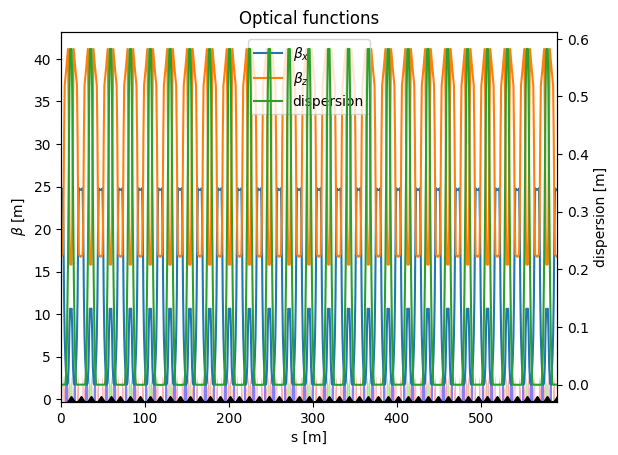

(<AxesSubplot:title={'center':'Optical functions'}, xlabel='s [m]', ylabel='$\\beta$ [m]'>,
 <AxesSubplot:ylabel='dispersion [m]'>,
 <AxesSubplot:>)

In [33]:
ring.plot_beta()
